In [5]:
from IPython.display import HTML

In [6]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [7]:
# %matplotlib inline
# %matplotlib notebook
# !jt -r

## 1 Statistische Verfahren
- Statistik (Winkeldaten)
    - Korrelationsmatrix
    - Differenz
    - ANOVA über die Differenzen (Faktor Messmethode x Faktor Bewegung x Faktor Armbeugung --> 4 x 4 x 2)
        - je für Flexion und Abduktion (statistisch nicht 100%ig korrekt)
    - Analyse der Peak-Werte
    
- Plots
     - Linien Plot
     - Orientation/Angle Plot
     - Box Plot
     

## 2 Methodik
- Geplante Bewegungsausführungen [5 x gestreckt, 5 x gebeugt]
    1. statisch Abduktion
    2. statisch Flexion
    3. von Neutral Null bis 180° Abduktion (langsam)
    4. von Neutral Null bis 180° Flexion (langsam)
    5. kreisend Abduktion
    6. kreisend Flexion
    7. Immitation Dirigentenbewegung
- 5 fache Wiederholung jeder Bewegungsausführung
- 2 VPs
- naming convention
     - VP_messmethode_winkel_bewegung_n
     - Bsp.: *01_myomotion_flexion_statisch_01*
- Zur Synchronisation der Messsysteme erfolgt zu Beginn jeder Messung eine Sprungbewegung
- Hardware
    - Intel Real Sense
    - Azure Kinect
    - Noraxon myoMOTION
    - Noraxon myoVIDEO
- stat. Hypothesen:
    - Haupteffekt Fakor Messmethode:
$$H_{0}: \mu_{messmethode_1} = \mu_{messmethode_2} = \mu_{messmethode_3} = \mu_{messmethode_4}$$
$$H_{1}: \mu_i \neq \mu_j $$
    - Haupteffekt Faktor Bewegung:
$$H_{0}: \mu_{bewegung_1} = \mu_{bewegung_2} = \mu_{bewegung_3} = \mu_{bewegung_4}$$
$$H_{1}: \mu_{bewegung_i} \neq \mu_{bewegung_j} $$
    - Haupteffekt Faktor Armbeugung:
$$H_{0}: \mu_{gestreckt} = \mu_{gebeugt}$$
$$H_{1}: \mu_{gestreckt} \neq \mu_{gebeugt}$$
    - Wechselwirkung Messmethode x Bewegung:
$$H_{0}: \mu_{ij} - (\mu_{i} - \mu_{j} - \mu_{ges}) = 0$$
$$H_{1}: \lnot H_{0}$$
    - Wechselwirkung Messmethode x Armbeugung:
$$H_{0}: \mu_{ij} - (\mu_{i} - \mu_{j} - \mu_{ges}) = 0$$
$$H_{1}: \lnot H_{0}$$
    - Wechselwirkung Armbeugung x Bewegung:
$$H_{0}: \mu_{ij} - (\mu_{i} - \mu_{j} - \mu_{ges}) = 0$$
$$H_{1}: \lnot H_{0}$$
    - Wechselwirkung Messmethode x Bewegung x Armbeugung:
    $$H_{0}: \mu_{ij} - (\mu_{i} - \mu_{j} - \mu_{ges}) = 0$$
    $$H_{1}: \lnot H_{0}$$
mit i, j = [1, .., 4] für Laufparameter Messmethode und Bewegung.

**Further Ideas** (not implemented)
- search for patterns in frequency distros on RGB cams
- filter RGB cam signals

In [29]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('dark')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from scipy import signal
import statsmodels.api as sm
from statsmodels.formula.api import ols

import upper_body_joints as up

In [30]:
def calc_diff(df1, df2, df3):
    pass

def remove_zeros(series):
    """
    search for all entries in the series that are 0. Replace zero values with mean of neighbouring values.
    
    returns same series with filled 0 values
    """
    zeros = series[series == 0]
    if len(zeros) != 0:
        if zeros.index[-1] == series.index[-1]: # if last index is 0, replace with previous value
            series.iloc[-1] = series.iloc[-2]
            zeros = series[series == 0]
        mean_array = np.array([series.loc[zeros.index - 1].values, series.loc[zeros.index + 1].values])
        series.loc[zeros.index] = np.mean(mean_array, axis=0)
    
    return series


def remove_valueChanges(series):
    """
    since v1.1
    if there is a sign change e.g. 68 to -68 within the following frame the sign of the last will be replaced by the former
    """
    # diff = series.abs() - series
    diff = series.abs()
    
    return diff


def check_timelog():
    """
    To Do - Use timelog from RGB-cams, for syncing
    """
    pass
    
    
def synchronize_systems(device):
    """
    find the first peak 

    """
    peaks_mm, _ = find_peaks(mm, prominence=(None,50))   
    
    pass


def moving_average(data, window=20):
    """
    filters data with moving average method
    """
    w = np.ones(window) / window
    return np.convolve(data, w, mode='same')
    

# Importing all data into a single data Frame

In [31]:
conditions = ["flexion_statisch_gestreckt", 
              "abduktion_statisch_gestreckt",
              "flexion_statisch_gebeugt",
              "abduktion_statisch_gebeugt",
              "flexion_nn180_gestreckt",
              "abduktion_nn180_gestreckt",
              "flexion_nn180_gebeugt",
              "abduktion_nn180_gebeugt",
              "flexion_kreisend_gestreckt",
              "abduktion_kreisend_gestreckt",
              "flexion_kreisend_gebeugt",
              "abduktion_kreisend_gebeugt",
"dirigent_gestreckt",
"dirigent_gebeugt"] 

multi_indeces = []

for cond in conditions:
    for device in ['mm', 'ki','rs', 'qu']:
        for num in ['0', '1', '2', '3', '4']:
            multi_indeces.append((cond, device, num))

df_flex = pd.DataFrame(np.zeros((2000, 280)), columns=multi_indeces)
df_flex.columns = pd.MultiIndex.from_tuples(df_flex.columns, names=['cond', 'device', 'num'])
df_flex

cond   flexion_statisch_gestreckt                                          \
device                         mm                       ki                  
num                             0    1    2    3    4    0    1    2    3   
0                             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1                             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2                             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3                             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4                             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...   
1995                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

cond         ... dirigent_gebeugt                                               
device       ...               rs                       qu                      
num       4  ...                0    1    2    3    4    0    1    2    3    4  
0       0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
1995    0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1996    0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1997    0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1998    0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1999    0.0  ...              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2000 rows x 280 columns]

In [32]:
N = 10
w = np.ones(N) / N
data = [1,2,3,4,5,5,5,5,5,5,5,5,5,5,5]

data_ma = np.convolve(data, w, mode='same')
data_ma

array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.4, 4.7, 4.9, 5. , 5. , 4.5, 4. ,
       3.5, 3. ])

In [33]:
# here we perform several steps:
# 1. Read in all data and exlcude what is not needed
# 2. clean any whitestrips and perform column-name formatting
# 3. upsampling of infra red cameras
testosteron=[]
files = glob.glob('data/*/*', recursive=True)
for file in files:
    for cond in df_flex.columns:
        if all(x in file for x in cond) and file[-5] == cond[-1] and 'RawData' not in file:
            if 'mm' in file:
                df = pd.read_csv(file, skiprows=3)
                cols = [col for i, col in enumerate(df.columns) if "Schulter RT-Flexion" in col or "Schulter RT-Abduktion" in col]
                df = df[cols]
                df.rename(columns = {cols[0] : 'flex', cols[1] : 'abdu'}, inplace=True)
                df_flex[cond] = df['flex'].values
       
            elif 'qu' in file:
                qtm = up.QTM(file)
                qtm.generate_jcs(['T8', 'C7'], ['LEL', 'ACR'])
                if 'flexion' in cond[0]:
                    df_flex[cond] = qtm.joint_angle('flexion')
                else:
                    df_flex[cond] = qtm.joint_angle('abduction')
            else:
                df = pd.read_csv(file, skiprows=0)
                df.columns = df.columns.str.strip()
                df.rename(columns = {'Flexion_Right' : 'flex', 'Abduction_Right' : 'abdu'}, inplace=True)
                df.drop(columns=['Flexion_Left', 'Abduction_Left'], inplace=True) # we don't need left sided data
                # remove zero values in data
                df['flex'] = remove_valueChanges(df['flex'])
                df['flex'] = remove_zeros(df['flex'])
                df.fillna(method='bfill', inplace=True)
#                 df['flex']
                df['flex'] = moving_average(df['flex'])
                # upsample depth cameras fps
                df_flex[cond] = signal.resample(df['flex'], 2000)

df_flex

cond   flexion_statisch_gestreckt                                     \
device                         mm                                      
num                             0           1          2           3   
0                        0.565140   -1.669788   0.049445    0.641976   
1                        0.560683   -1.663854   0.051055    0.646532   
2                        0.556227   -1.657914   0.052666    0.651088   
3                        0.551772   -1.651968   0.054276    0.655643   
4                        0.546765   -1.646358   0.056257    0.660774   
...                           ...         ...        ...         ...   
1995                   102.567669  103.265296  98.950738  100.149549   
1996                   102.547631  103.273354  98.959560  100.155487   
1997                   102.528463  103.280865  98.966731  100.161460   
1998                   102.509930  103.287526  98.973262  100.166759   
1999                   102.493056  103.293830  98.978377  100.172585   

cond                                                                       \
device                     ki                                               
num              4          0          1          2          3          4   
0        -1.710729   9.990032   9.559232   7.873239   7.741064   8.136209   
1        -1.705035   6.342685   5.154663   3.693019   3.166235   3.851504   
2        -1.699342   4.921966   3.433391   2.038590   1.440814   2.082178   
3        -1.693649   5.455413   4.032263   2.574671   2.154942   2.514330   
4        -1.687315   7.381972   6.224144   4.624497   4.508104   4.506510   
...            ...        ...        ...        ...        ...        ...   
1995    100.785716  47.413906  53.800624  49.743138  54.017389  51.070370   
1996    100.782564  39.941593  45.253908  41.628165  45.178792  42.560352   
1997    100.779327  31.579053  35.446793  32.344086  34.931166  32.998311   
1998    100.775589  23.218280  25.487947  22.930893  24.471044  23.407235   
1999    100.770947  15.769731  16.534923  14.471264  15.055848  14.831089   

cond    ... dirigent_gebeugt                                              \
device  ...               rs                                               
num     ...                0          1          2          3          4   
0       ...         6.324374   3.822948   9.137756  11.515032  10.922757   
1       ...         3.155113   0.112383   5.574032   8.073874  10.355026   
2       ...         1.940568  -1.266211   4.281043   6.809540  10.328805   
3       ...         2.407954  -0.658484   4.956920   7.434875  10.758009   
4       ...         4.008937   1.270501   6.999375   9.373486  11.491619   
...     ...              ...        ...        ...        ...        ...   
1995    ...        37.787628  41.730637  46.410097  47.141906  19.128370   
1996    ...        31.857664  34.454265  39.029892  40.151853  17.343863   
1997    ...        24.926215  26.044213  30.700014  32.207247  15.428130   
1998    ...        17.804968  17.478326  22.336078  24.198617  13.588077   
1999    ...        11.359120   9.784248  14.885209  17.045581  12.030990   

cond                                                           
device         qu                                              
num             0          1          2          3          4  
0       18.717222  34.376819  16.441191   8.381107  10.643340  
1       19.418928  35.663251  15.267562   8.426594  10.893569  
2       20.142725  36.906306  14.100790   8.449758  11.153221  
3       20.887203  38.132167  12.926635   8.464248  11.487402  
4       21.649338  39.318620  11.776564   8.482649  11.873047  
...           ...        ...        ...        ...        ...  
1995     7.884749  83.402523  52.620709  41.533592  39.730226  
1996     7.877511  84.521057  52.485967  39.754747  38.015785  
1997     7.869821  85.620839  52.494041  37.996050  36.360989  
1998     7.853869  86.760681  52.606219  36.263592  34.743629  
1999     7.8278

In [34]:
# Let's say it has not been the smartest move to process the multiindexing on columns -.-
new_cols = [[],[],[]]
for col in df_flex.columns:
    if 'flexion' in col[0]:
        new_cols[0].append(col)
    elif 'abduktion' in col[0]:
        new_cols[1].append(col)
    else:
        new_cols[2].append(col)

# splitting the big df into smaller ones; we will analyze them separately
df_diri = df_flex[new_cols[2]]
df_abdu = df_flex[new_cols[1]]
df_flex = df_flex[new_cols[0]]

# First look at the data

We will now do a line plot on all of our data files. This is time consuming and efforts CPU-performance, but we do it for the following reasons:

- check if we imported all files correctly to the corresponding conditions
- see if there are any strange events in the signals
- see if the devices are in sync (they won't be)


In [35]:
flex = pd.DataFrame(df_flex.unstack(level=3))
flex.reset_index()

,cond,device,num,level_3,0
0,flexion_statisch_gestreckt,mm,0,0,0.565140
1,flexion_statisch_gestreckt,mm,0,1,0.560683
2,flexion_statisch_gestreckt,mm,0,2,0.556227
3,flexion_statisch_gestreckt,mm,0,3,0.551772
4,flexion_statisch_gestreckt,mm,0,4,0.546765
...,...,...,...,...,...
239995,flexion_kreisend_gebeugt,qu,4,1995,3.786347
239996,flexion_kreisend_gebeugt,qu,4,1996,3.779551
239997,flexion_kreisend_gebeugt,qu,4,1997,3.780580
239998,flexion_kreisend_gebeugt,qu,4,1998,3.782920


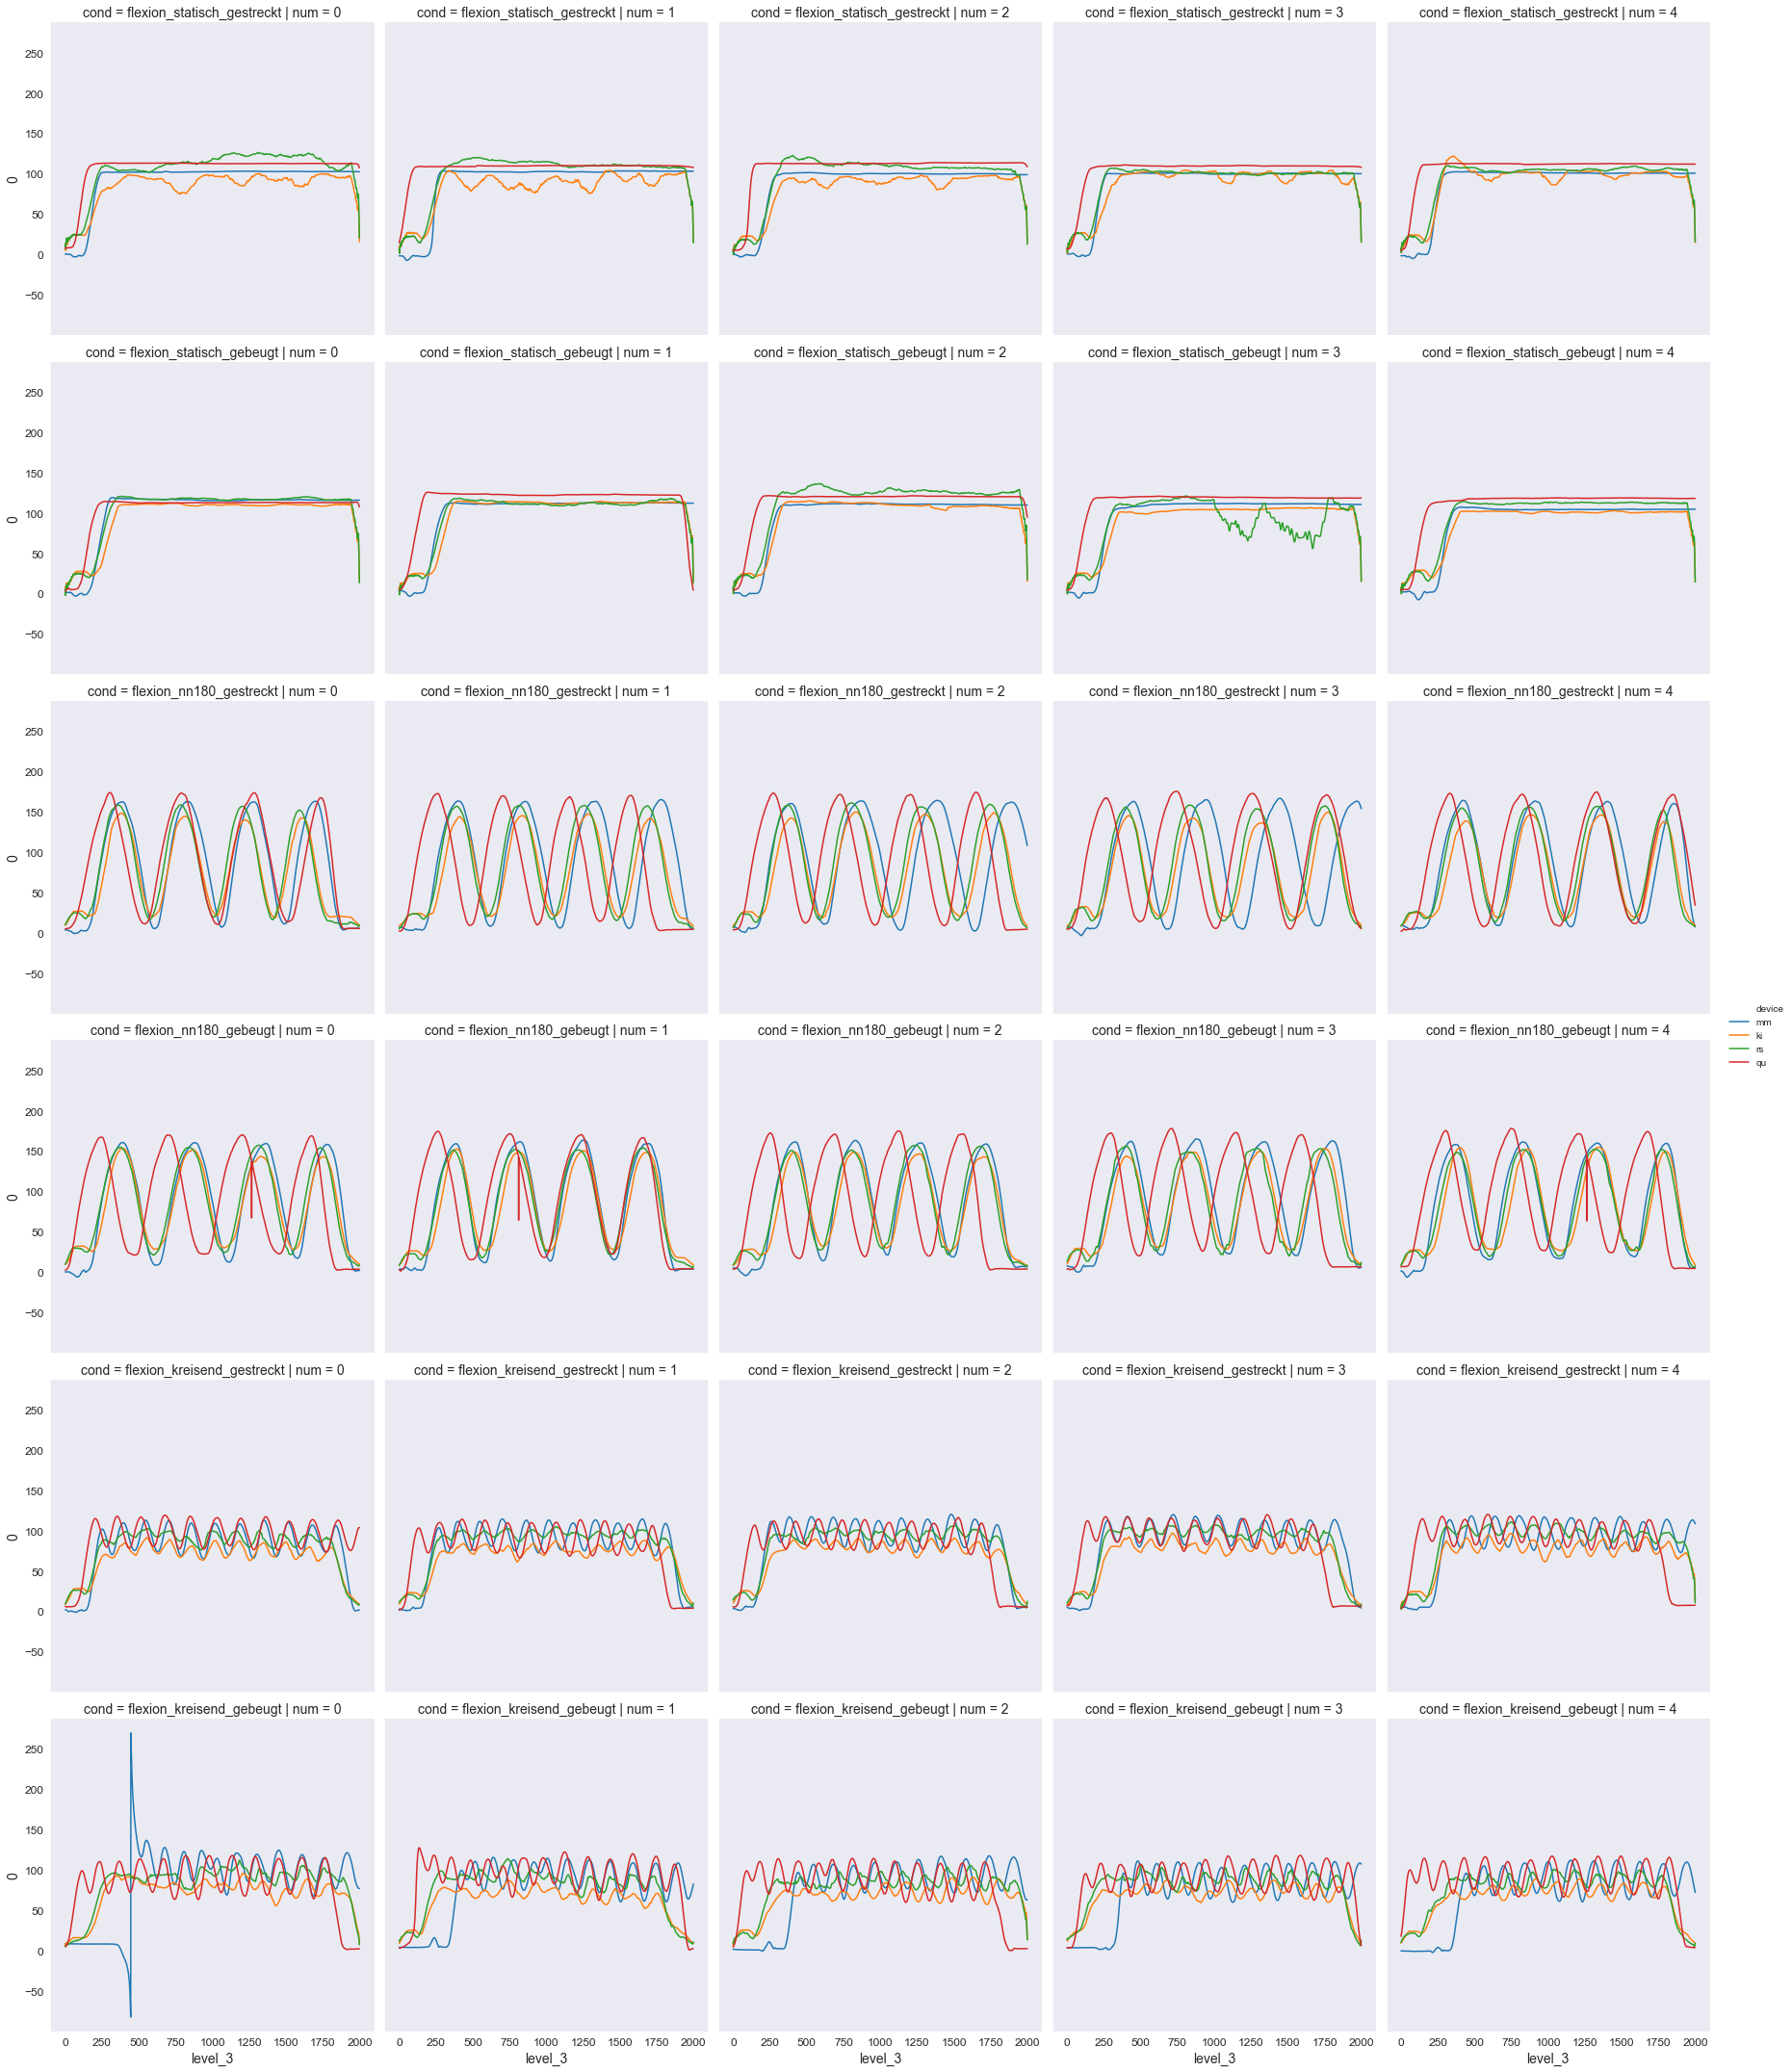

In [36]:
all_flex_plot = sns.relplot(data=flex.reset_index(), x='level_3', y=0, kind='line', hue='device', row='cond', col='num')
all_flex_plot.savefig('flexes.pdf', dpi=300)

In [25]:
abdu = pd.DataFrame(df_abdu.unstack(level=3))
abdu.reset_index()

,cond,device,num,level_3,0
0,abduktion_statisch_gestreckt,mm,0,0,2.980359
1,abduktion_statisch_gestreckt,mm,0,1,2.974526
2,abduktion_statisch_gestreckt,mm,0,2,2.968710
3,abduktion_statisch_gestreckt,mm,0,3,2.962911
4,abduktion_statisch_gestreckt,mm,0,4,2.957525
...,...,...,...,...,...
239995,abduktion_kreisend_gebeugt,qu,4,1995,7.008423
239996,abduktion_kreisend_gebeugt,qu,4,1996,7.002089
239997,abduktion_kreisend_gebeugt,qu,4,1997,6.998561
239998,abduktion_kreisend_gebeugt,qu,4,1998,6.990897


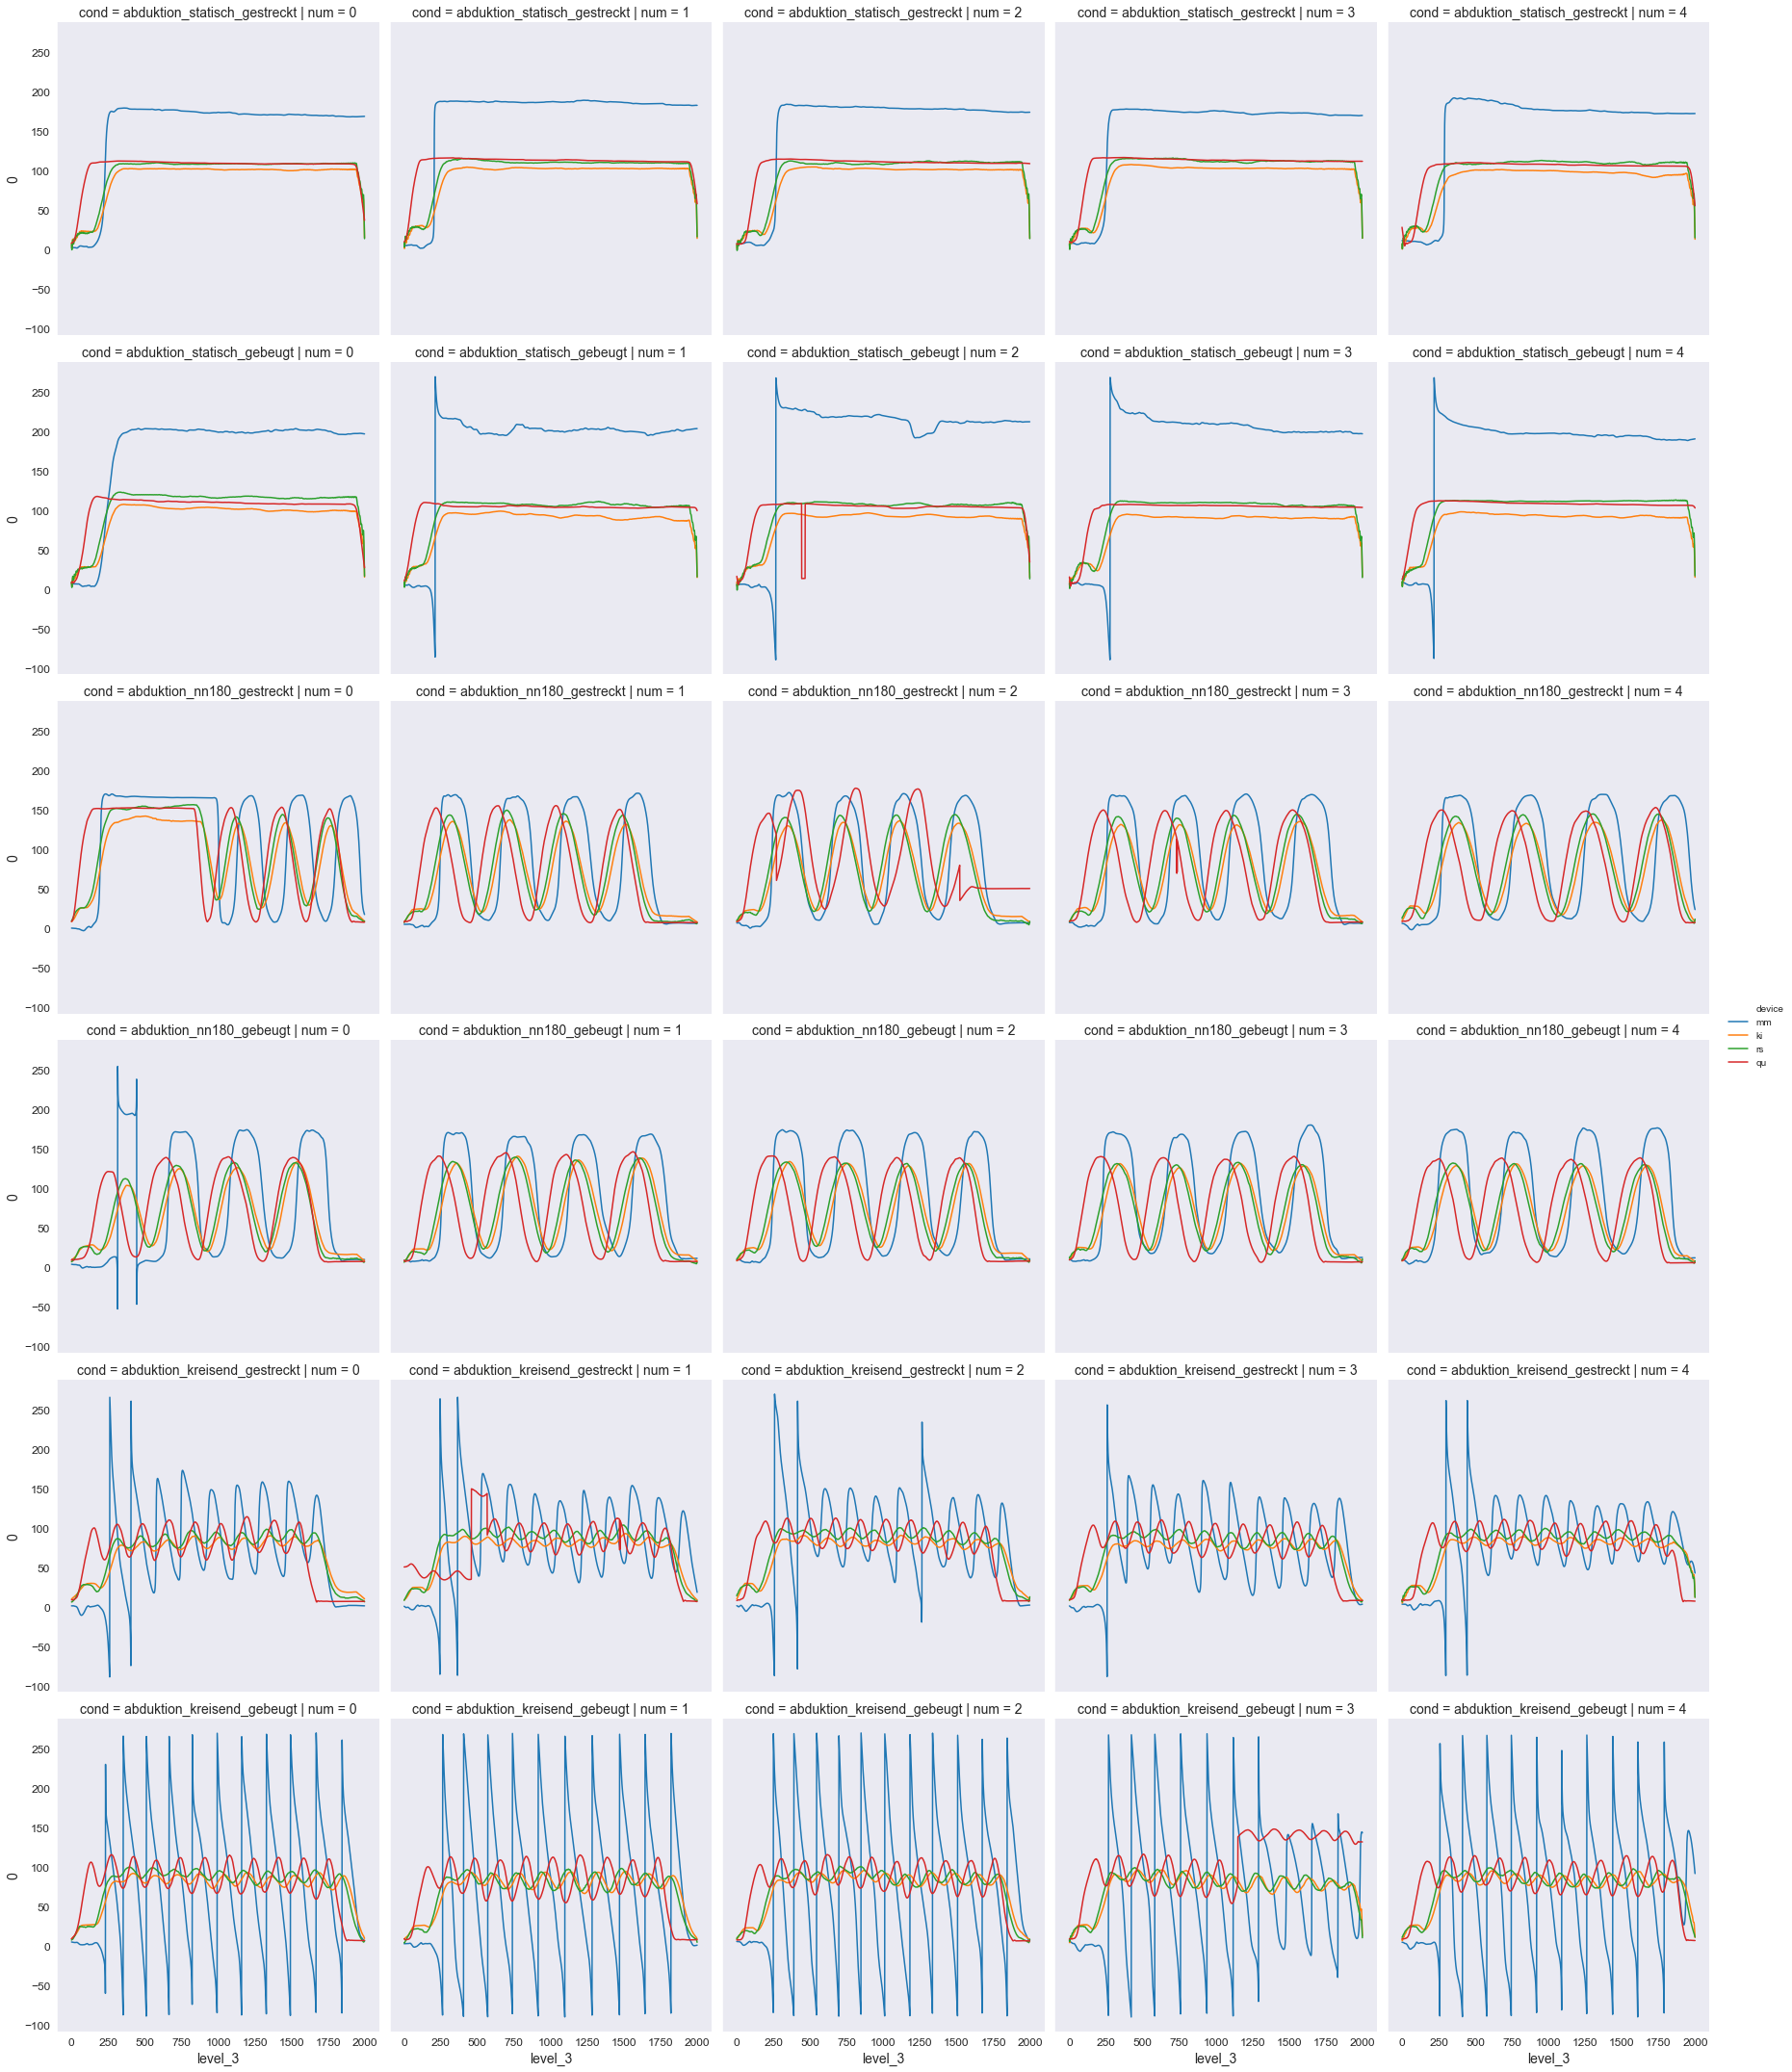

In [37]:
all_abdu_plot = sns.relplot(data=abdu.reset_index(), x='level_3', y=0, kind='line', hue='device', row='cond', col='num')
all_abdu_plot.savefig('abdus.pdf', dpi=300)

In [27]:
diri = pd.DataFrame(df_diri.unstack(level=3))
diri.reset_index()

,cond,device,num,level_3,0
0,dirigent_gestreckt,mm,0,0,-0.305887
1,dirigent_gestreckt,mm,0,1,-0.300557
2,dirigent_gestreckt,mm,0,2,-0.295226
3,dirigent_gestreckt,mm,0,3,-0.289896
4,dirigent_gestreckt,mm,0,4,-0.284223
...,...,...,...,...,...
79995,dirigent_gebeugt,qu,4,1995,7.884749
79996,dirigent_gebeugt,qu,4,1996,7.877511
79997,dirigent_gebeugt,qu,4,1997,7.869821
79998,dirigent_gebeugt,qu,4,1998,7.853869


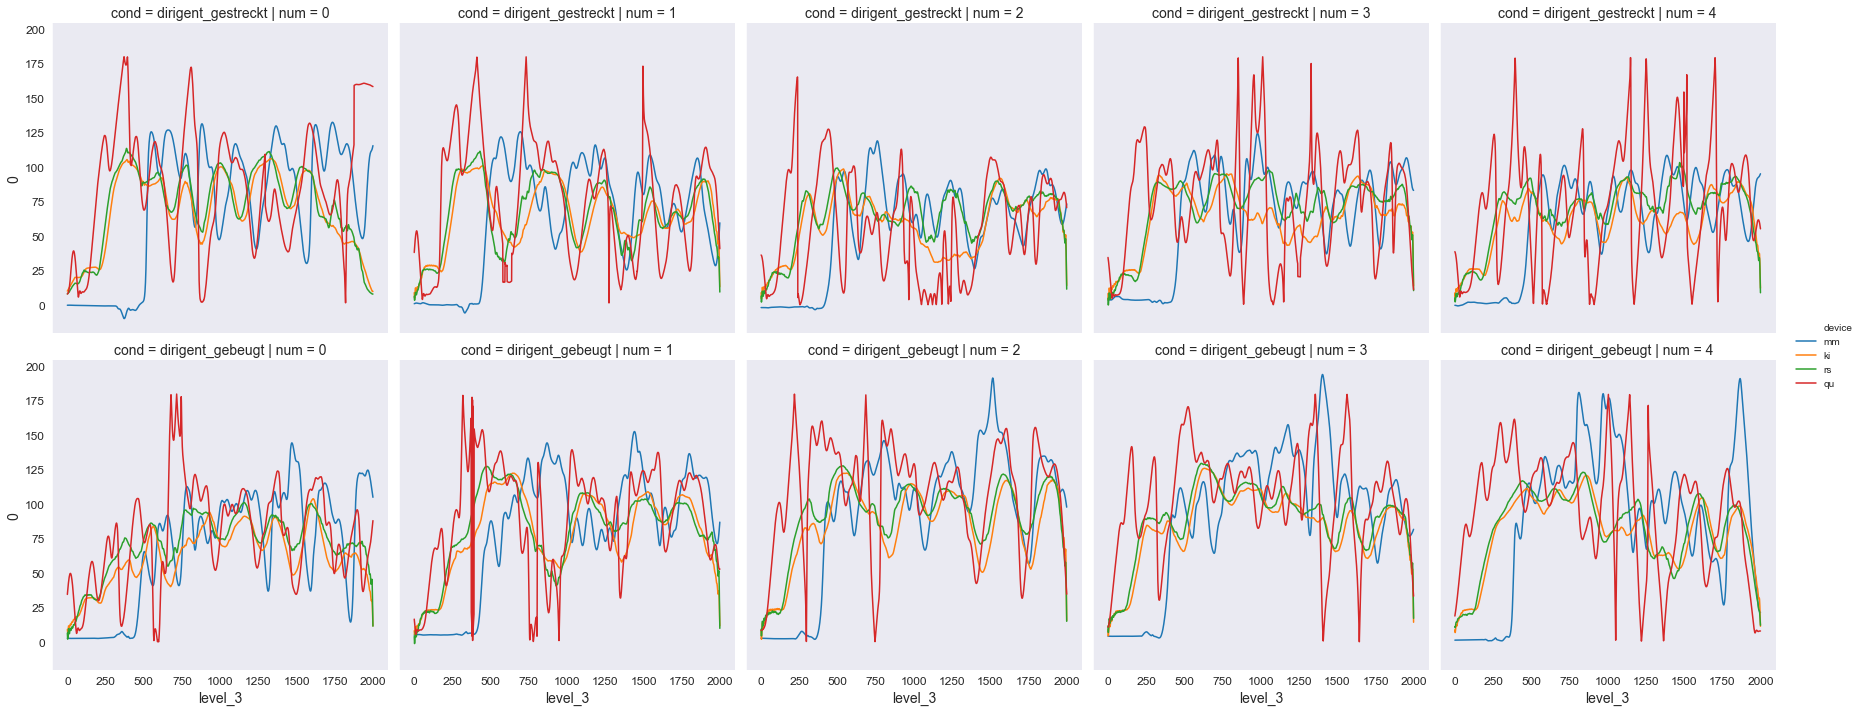

In [38]:
all_diri_plot = sns.relplot(data=diri.reset_index(), x='level_3', y=0, kind='line', hue='device', row='cond', col='num')
all_diri_plot.savefig('diris.pdf', dpi=300)